<a href="https://colab.research.google.com/github/samitha278/CoreLlama/blob/main/positional_encoding_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn

import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

### Binary value function

In [6]:
def _get_binary(value):

    if value == 1 or value == 0 :
        return f"{value}"

    binary = f"{_get_binary(value//2)}{value%2}"

    return binary

bin = _get_binary(16)
print(bin)
bin_list = list(map(int,bin))
tensor = torch.tensor(bin_list)
print(tensor)

10000
tensor([1, 0, 0, 0, 0])


In [7]:
zeros = torch.zeros((4,6))
zeros[2,6-3:] = torch.tensor([1,2,3])
zeros

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 2., 3.],
        [0., 0., 0., 0., 0., 0.]])

# Binary Positional Encoding

### Slow version

In [8]:
class BinaryPE():

    def __init__(self,max_len,d_model):

        self.encoding = self._precompute_binary(max_len,d_model)


    def _get_binary(self,value):

        if value == 1 or value == 0 :
            return f"{value}"

        binary = f"{self._get_binary(value//2)}{value%2}"

        return binary


    def _precompute_binary(self,max_len,d_model):

        binary_table = torch.zeros((max_len,d_model))

        for pos in range(max_len):
            binary = list(map(int,self._get_binary(pos)))
            print(binary)

            binary_table[pos,d_model-len(binary):] = torch.tensor(binary)

        return binary_table



    def forward(self,ids):
        return self.encoding(ids)


In [9]:
binary_pe = BinaryPE(4,6)
binary_pe.encoding

[0]
[1]
[1, 0]
[1, 1]


tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.]])

### Optimized version

In [10]:
class BinaryPositionalEncoding(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        # to move with model to device(GPU)
        self.register_buffer('encoding', self._precompute_binary(max_len, d_model))


    def _precompute_binary(self, max_len, d_model):

        positions = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]

        # bit indices (msb to lsb)
        bit_indices = torch.arange(d_model - 1, -1, -1).unsqueeze(0)  # [1, d_model]

        # right shift positions by bit_indices and mask with 1
        binary_table = (positions >> bit_indices) & 1     # braodcast tensors

        return binary_table.float()


    def forward(self,ids):
        return self.encoding[ids]

For position 5 (binary 0101):

- (5 >> 3) & 1 = (0) & 1 = 0  # MSB (bit 3)
- (5 >> 2) & 1 = (1) & 1 = 1  # bit 2
- (5 >> 1) & 1 = (2) & 1 = 0  # bit 1
- (5 >> 0) & 1 = (5) & 1 = 1  # LSB (bit 0)

Result: [0, 1, 0, 1]

In [11]:
binary_pe = BinaryPositionalEncoding(8,12)
binary_pe(torch.arange(0,8))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

## Visualize as HeatMap

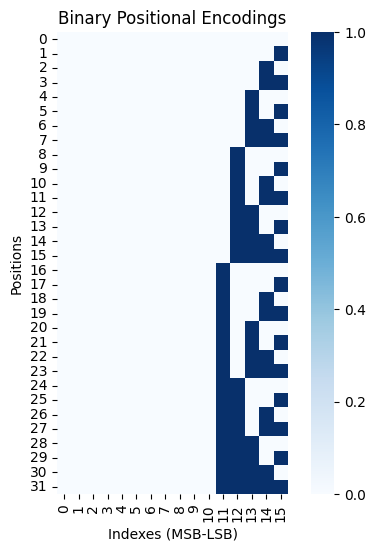

In [12]:
max_len = 32
d_model = 16

binary_pe = BinaryPositionalEncoding(max_len,d_model)
encodings = binary_pe(torch.arange(0,max_len))


plt.figure(figsize=(6, 6))
sns.heatmap(encodings.numpy(), cmap='Blues',square=True)
plt.title(f'Binary Positional Encodings')
plt.xlabel('Indexes (MSB-LSB)')
plt.ylabel('Positions')
plt.show()

- Here binary table is MSB-LSB (natural way how we feel) # 8 = [1,0,0,0]

- When adding binary PE to Token Embedding vector there is no mathematical rule saying binary pe must be MSB-LSB or LSB-MSB.

- When we add it to token embedding use any way model will adapt.
- Both work only consistency matter

# Sinusoidal Positional Encoding

- Problem with Binary Positional Encoding is discontinuity
- Then take sin to replace binary

$$
PE_{(pos, i)} = \sin\left({pos}.\omega_i\right) \\
\omega_i = \frac{1}{10000^{i/d_{model}}} \\
PE_{(pos, i)} = \sin\left(\frac{pos}{10000^{i/d_{model}}}\right)$$


In [13]:
class SinusoidalPE_v1(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.d_model = d_model
        self.register_buffer('encoding', self._precompute_sinusoidal(max_len, d_model))


    def _get_sinusoidal(self,pos,i):

        return math.sin(pos/10000**(i/d_model))


    def _precompute_sinusoidal(self,max_len,d_model):

        sinusoidal_table = torch.zeros((max_len,d_model))

        # loop way : bad ~ x1000 times decrease performance
        for pos in range(max_len):
            for i in range(d_model):
                sinusoidal_table[pos,i] = self._get_sinusoidal(pos,i)

        return sinusoidal_table


    def forward(self,ids):
        return self.encoding[ids]


In [14]:
sin_pe = SinusoidalPE_v1(4,6)
sin_pe(torch.arange(0,4))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.5332, 0.3110, 0.1769, 0.0998, 0.0562],
        [0.9093, 0.9021, 0.5911, 0.3482, 0.1987, 0.1122],
        [0.1411, 0.9933, 0.8126, 0.5085, 0.2955, 0.1679]])

In [15]:
class SinusoidalPE_v2(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.d_model = d_model
        self.register_buffer('encoding', self._precompute_sinusoidal(max_len, d_model))



    def _precompute_sinusoidal(self,max_len,d_model):

        positions = torch.arange(max_len).unsqueeze(1)  # [max_length , 1]
        indexes = torch.arange(d_model).unsqueeze(0)    # [1,d_model]

        sinusoidal_table = torch.sin((positions/(10000**(indexes/d_model))))

        return sinusoidal_table


    def forward(self,ids):
        return self.encoding[ids]


In [16]:
max_len = 4
d_model = 6

positions = torch.arange(max_len).unsqueeze(1)  # [max_length , 1]
indexes = torch.arange(d_model).unsqueeze(0)    # [1,d_model]

sinusoidal_table = torch.sin((positions/(10000**(indexes/d_model))))

sinusoidal_table

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.4147e-01, 2.1378e-01, 4.6399e-02, 9.9998e-03, 2.1544e-03, 4.6416e-04],
        [9.0930e-01, 4.1768e-01, 9.2698e-02, 1.9999e-02, 4.3089e-03, 9.2832e-04],
        [1.4112e-01, 6.0226e-01, 1.3880e-01, 2.9995e-02, 6.4633e-03, 1.3925e-03]])

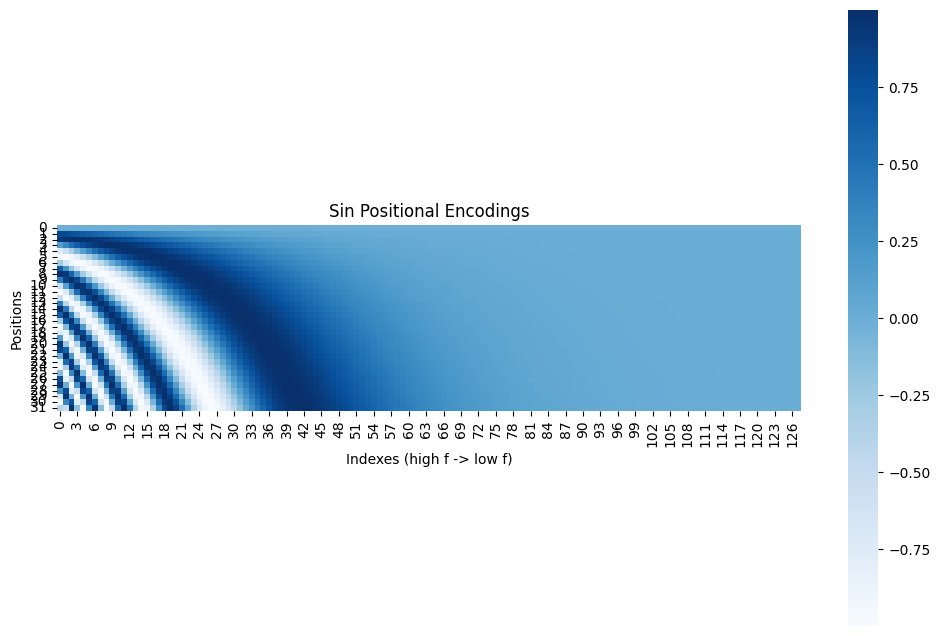

In [28]:
max_len = 32
d_model = 128

sin_pe = SinusoidalPE_v2(max_len,d_model)
encodings = sin_pe(torch.arange(0,max_len))


plt.figure(figsize=(12, 8))
sns.heatmap(encodings.numpy(), cmap='Blues',square=True)
plt.title(f'Sin Positional Encodings')
plt.xlabel('Indexes (high f -> low f)')
plt.ylabel('Positions')
plt.show()

- Here sinusoidal table MSB - high frequencies , LSB - Low frequencies

- [i = 0, i = 1 , i = 2 , .. , i = d_model]  , i=0 -> high frequency , i increases frequency decreases

- Like giving each token unique address : like barcode
- Low frequency dimensions = Which continent? (changes slowly)

- Medium frequency = Which country?

- High frequency = Which street? (changes rapidly)

- All together = Exact location



- high frquencies to low frequencies
- Pos    1: 10000000
- Pos    2: 01000000
- Pos   40: 00010100
- Pos   41: 10010100
- Pos  200: 00010011
- Pos  201: 10010011
- Pos 1000: 00010111
- Pos 1001: 10010111


- Pos    1 tensor([0.8415, 0.5403, 0.0998, 0.9950, 0.0100, 0.9999, 0.0010, 1.0000])
- Pos    2 tensor([ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000])
- Pos   40 tensor([ 0.7451, -0.6669, -0.7568, -0.6536,  0.3894,  0.9211,  0.0400,  0.9992])
- Pos   41 tensor([-0.1586, -0.9873, -0.8183, -0.5748,  0.3986,  0.9171,  0.0410,  0.9992])
- Pos  200 tensor([-0.8733,  0.4872,  0.9129,  0.4081,  0.9093, -0.4161,  0.1987,  0.9801])
- Pos  201 tensor([-0.0619,  0.9981,  0.9491,  0.3149,  0.9051, -0.4252,  0.1996,  0.9799])
- Pos 1000 tensor([ 0.8269,  0.5624, -0.5064,  0.8623, -0.5440, -0.8391,  0.8415,  0.5403])
- Pos 1001 tensor([ 0.9200, -0.3919, -0.4177,  0.9086, -0.5524, -0.8336,  0.8420,  0.5395])

- model identyfy near tokens by first few dementions : high frequincies
- positions 1,2 and 40,41 difference identify by looking middlde dimentions ; mid frequencies
- positioins 1,2 and 1000,1001 immediately identify by looking last low frequncy dimentions

## Similarity between positional encodings

$$\langle PE_m, PE_n \rangle = \langle \ldots, \sin(m \cdot \omega_i), \ldots \rangle \cdot \langle \ldots, \sin(n \cdot \omega_i), \ldots \rangle$$

$$= \sum_{i=1}^{d_{model}} \sin(m \cdot \omega_i) \sin(n \cdot \omega_i)$$

$$= \sum_{i=1}^{d_{model}} \frac{1}{2} \left[\cos((m-n) \cdot \omega_i) - \cos((m+n) \cdot \omega_i)\right]$$

$$= \frac{1}{2} \sum_{i=1}^{d_{model}} \cos((m-n) \cdot \omega_i) - \frac{1}{2} \sum_{i=1}^{d_{model}} \cos((m+n) \cdot \omega_i)$$

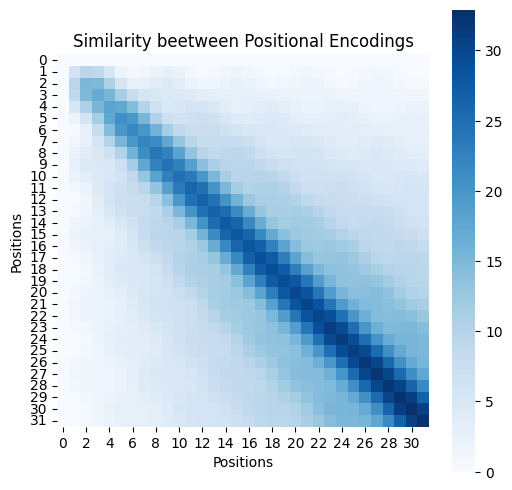

In [30]:
similarity = torch.matmul(encodings,encodings.T)

plt.figure(figsize=(6,6))
sns.heatmap(similarity.numpy(), cmap='Blues',square=True)
plt.title(f'Similarity beetween Positional Encodings')
plt.xlabel('Positions')
plt.ylabel('Positions')
plt.show()

## In Attention is All you need paper proposed way
- Problem with only taking sin is sin(0)=0 , 0th position vector is [0,0,...]
- Then take sin for even i , cos for odd i

$$PE(pos,i) = \begin{cases}
\sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) & \text{for even } i \\
\cos\left(\frac{pos}{10000^{2i/d_{model}}}\right) & \text{for odd } i
\end{cases}$$

- Nice representation

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

## Rotary Positional Encoding - RoPE